In [1]:
# Install igraph
!pip install python-igraph

# Install matplotlib (usually comes with Anaconda/Jupyter, but good to ensure)
!pip install matplotlib

# Install numpy (usually comes with Anaconda/Jupyter, but good to ensure)
!pip install numpy

# Install pandas (if you're using it for data loading as in your previous code)
!pip install pandas

# Install scipy (for ConvexHull)
!pip install scipy

In [2]:
import igraph as ig
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors 
from scipy.spatial import ConvexHull
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.patches import Patch 

# Community detection guide

## Generating and visualizing communities

First, we load the Zachary Karate Club graph, a well-known benchmark for community detection. We then ensure the graph is connected, focusing on its largest connected component if necessary.

In [3]:
g = ig.Graph.Famous("Zachary")

# Ensuring the graph is connected (can be useful for clustering)
if not g.is_connected():
    components = g.components()
    g = g.subgraph(components.giant())

Now, we will visualize the graph (without any clustering yet)

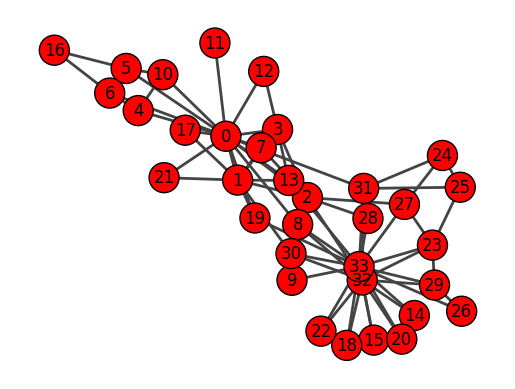

In [4]:
layout = g.layout("fr")
_ = ig.plot(g, layout=layout, vertex_label=g.vs.indices)

### 1. Generating communities
Let's continue with the clustering, using the Louvain algorithm first:

In [5]:
clusters = g.community_multilevel()

### Visualizing communities
Next, we can create a few visualizations using igraph and matplotlib

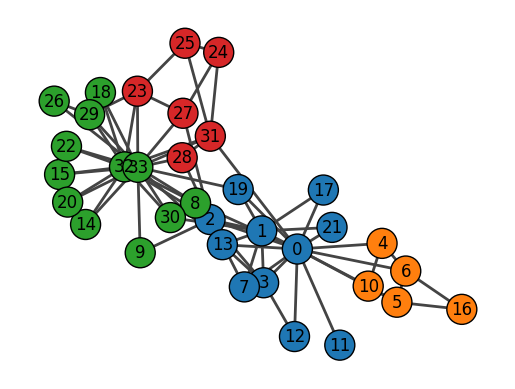

In [6]:
def simple_ig_viz(graph, communities):
    # Assign a color to each node based on community
    colors_map = matplotlib.colormaps["tab10"]
    graph.vs["color"] = [colors_map(cluster) for cluster in communities.membership]

    # Layout and plot
    layout = graph.layout("fr")  # Fruchterman-Reingold
    _ = ig.plot(graph, layout=layout, vertex_size=30, vertex_label=graph.vs.indices, bbox=(600,600))
simple_ig_viz(g, clusters)

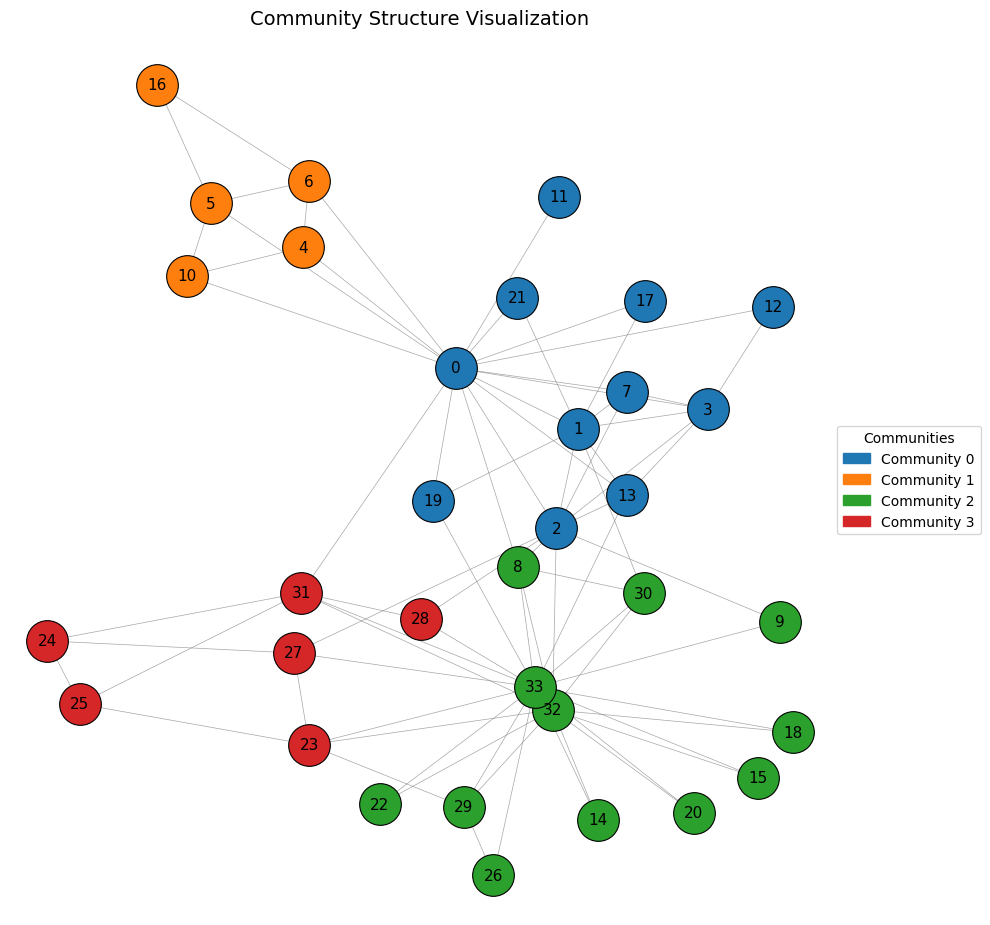

In [7]:
def simple_matplotlib_viz(graph, communities, title="Community Structure Visualization"):
    membership = communities.membership
    num_communities = len(set(membership)) # Get the total number of unique communities

    fig, ax = plt.subplots(figsize=(10, 9)) # Slightly larger figure for legend space
    layout = graph.layout("fr")  # Fruchterman-Reingold
    coords = np.array(layout.coords)

    # Define a color map for communities
    # Using 'tab10' for up to 10 communities, fall back to a colormap for more
    if num_communities <= 10:
        colors_map = matplotlib.colormaps["tab10"]
    else:
        colors_map = matplotlib.colormaps["viridis"] # Or 'plasma', 'cividis', etc.

    # Draw edges
    for edge in graph.es:
        src, tgt = edge.tuple
        x, y = coords[[src, tgt]].T
        ax.plot(x, y, color="gray", linewidth=0.5, zorder=1, alpha=0.7)

    # Draw nodes and add labels
    for idx, (x, y) in enumerate(coords):
        community_id = membership[idx]
        node_color = colors_map(community_id % colors_map.N if num_communities > colors_map.N else community_id)
        
        ax.scatter(x, y, s=900,
                   color=node_color,
                   edgecolors='black', linewidths=0.8, zorder=2)
        
        ax.text(x, y, str(idx),
                fontsize=11,
                color='black',
                ha='center',
                va='center',
                zorder=3)

    ax.set_axis_off()
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend on the right

    plt.title(title, fontsize=14, pad=15)

    # --- Add Legend for Communities ---
    legend_handles = []
    # Create a Patch for each unique community
    # Iterate through unique community IDs to ensure all are included
    unique_community_ids = sorted(list(set(membership)))
    
    for comm_id in unique_community_ids:
        # Determine the color for this community ID
        # This mirrors how the colors were assigned to nodes
        color_for_legend = colors_map(comm_id % colors_map.N if num_communities > colors_map.N else comm_id)
        
        # Create a Patch (a colored square) for the legend
        patch = Patch(color=color_for_legend, label=f'Community {comm_id}')
        legend_handles.append(patch)

    # Add the legend to the axes
    # loc='center left' places it to the left of the bounding box
    # bbox_to_anchor=(1, 0.5) places the bounding box of the legend at (1, 0.5) in axes coordinates,
    # which is just outside the right edge, centered vertically.
    ax.legend(handles=legend_handles, title="Communities", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

    plt.show()
    
    
simple_matplotlib_viz(g, clusters)

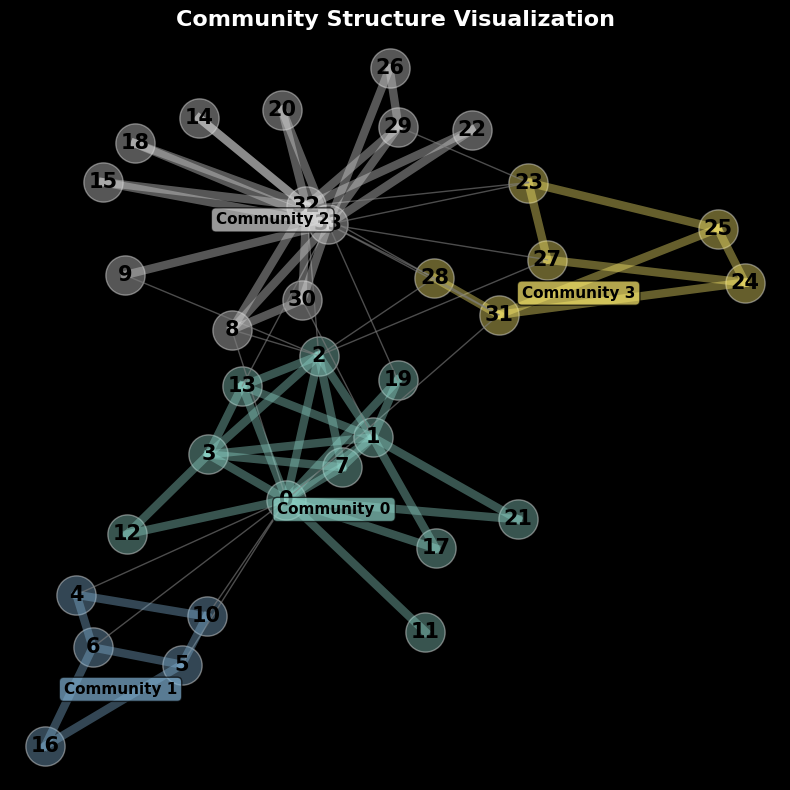

In [8]:
def community_neon_viz(graph, communities, title="Community Structure Visualization"):
    """Neon-style community visualization"""
    figsize=(8, 8)
    layout = graph.layout("fr")  # Fruchterman-Reingold
    coords = np.array(layout.coords)
    x_coords = coords[:, 0]
    y_coords = coords[:, 1]
    
    # Create distinct colors for each community
    n_communities = len(communities)
    colors = plt.cm.Set3(np.linspace(0, 1, n_communities))
    
    fig, ax = plt.subplots(figsize=figsize, facecolor='black')
    ax.set_facecolor('black')
    
    # Draw edges with community-based colors
    for edge in graph.es:
        source_idx = edge.source
        target_idx = edge.target
        source_community = communities.membership[source_idx]
        target_community = communities.membership[target_idx]
        
        x_line = [x_coords[source_idx], x_coords[target_idx]]
        y_line = [y_coords[source_idx], y_coords[target_idx]]
        
        # Different edge styles for intra vs inter-community edges
        if source_community == target_community:
            # Intra-community edges - bright and thick
            edge_color = colors[source_community]
            width = 6
            alpha = 0.4
            ax.plot(x_line, y_line, color=edge_color, linewidth=width, alpha=alpha)
        else:
            # Inter-community edges - dim and thin
            ax.plot(x_line, y_line, color='gray', linewidth=1, alpha=0.6)
    
    # Draw nodes grouped by community
    for comm_idx, community in enumerate(communities):
        community_nodes = list(community)
        community_x = [x_coords[node] for node in community_nodes]
        community_y = [y_coords[node] for node in community_nodes]
        
        color = colors[comm_idx]
        
        # Glow effect for community nodes
        size = 800
        alpha = 0.4
        ax.scatter(community_x, community_y, s=size, c=[color], 
                  alpha=alpha, edgecolors='white', linewidth=1)
    
    # Add node labels
    for i in range(graph.vcount()):
        ax.text(x_coords[i], y_coords[i], str(i), 
               ha='center', va='center', fontsize=15, 
               color='black', fontweight='bold', zorder=3)
    
    # Add community labels
    for comm_idx, community in enumerate(communities):
        community_nodes = list(community)
        if community_nodes:  # Check if community is not empty
            # Calculate community center
            center_x = np.mean([x_coords[node] for node in community_nodes])
            center_y = np.mean([y_coords[node] for node in community_nodes])
            
            ax.text(center_x, center_y - 0.6, f'Community {comm_idx}', 
                   ha='center', va='center', fontsize=11, 
                   color='black', fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[comm_idx], alpha=0.7))
    
    ax.set_title(title, color='white', fontsize=16, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

community_neon_viz(g, clusters)

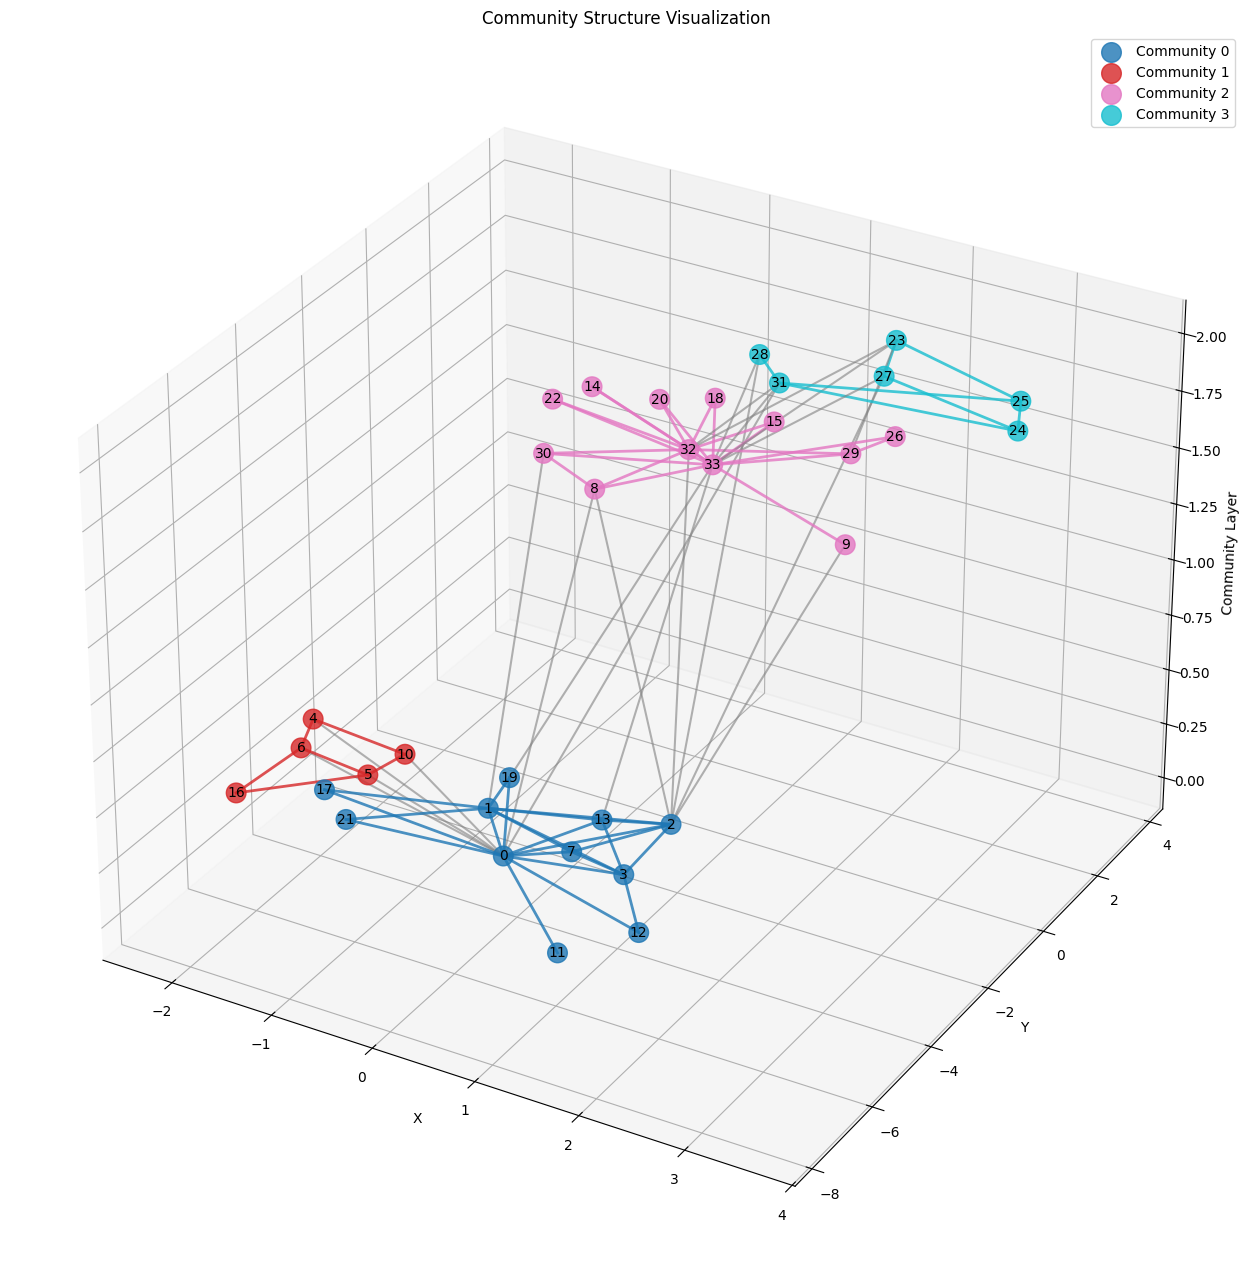

In [9]:
def create_3d_community_viz(graph, communities, title="Community Structure Visualization"):
    """3D visualization with communities as layers"""
    figsize = (16, 16)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Assign Z-coordinates based on community membership
    n_communities = len(communities)
    z_levels = np.linspace(0, 2, n_communities)
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_communities))
    
    # Generate 2D layout first
    layout = graph.layout("fr")
    coords = np.array(layout.coords)
    
    # Create 3D coordinates
    x_coords = coords[:, 0]
    y_coords = coords[:, 1]
    z_coords = [z_levels[communities.membership[i]] for i in range(graph.vcount())]
    
    # Draw edges
    for edge in graph.es:
        source_idx = edge.source
        target_idx = edge.target
        
        x_line = [x_coords[source_idx], x_coords[target_idx]]
        y_line = [y_coords[source_idx], y_coords[target_idx]]
        z_line = [z_coords[source_idx], z_coords[target_idx]]
        
        # Color edges by community
        if communities.membership[source_idx] == communities.membership[target_idx]:
            color = colors[communities.membership[source_idx]]
            alpha = 0.8
            width = 2
        else:
            color = 'gray'
            alpha = 0.6
            width = 1.5
            
        ax.plot(x_line, y_line, z_line, color=color, alpha=alpha, linewidth=width)
    
    
    # Add labels
    for i in range(graph.vcount()):
        ax.text(x_coords[i], y_coords[i], z_coords[i], str(i), fontsize=10, zorder=11, ha='center', va='center', )
        
    # Draw nodes by community
    for comm_idx, community in enumerate(communities):
        community_nodes = list(community)
        if community_nodes:
            comm_x = [x_coords[node] for node in community_nodes]
            comm_y = [y_coords[node] for node in community_nodes]
            comm_z = [z_coords[node] for node in community_nodes]
            
            ax.scatter(comm_x, comm_y, comm_z, c=[colors[comm_idx]], 
                      s=200, alpha=0.8, linewidth=1,
                      label=f'Community {comm_idx}')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Community Layer')
    ax.set_title(title)
    ax.legend()
    
    plt.show()

create_3d_community_viz(g, clusters)

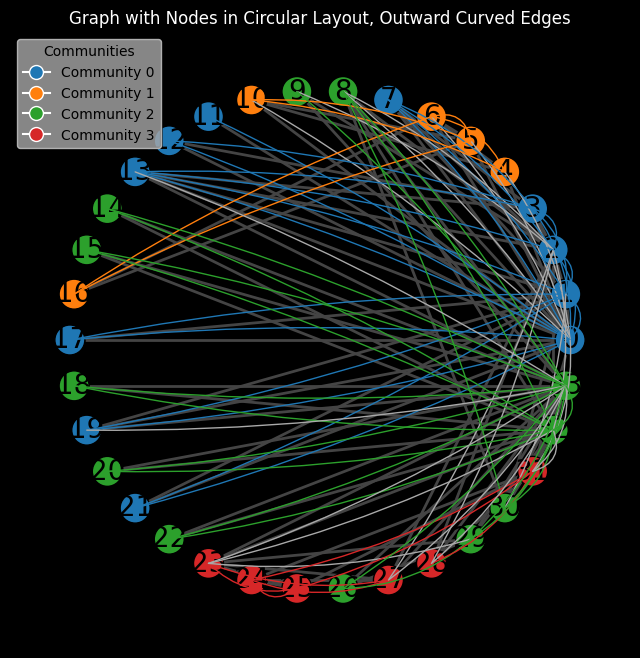

In [10]:
def circular_community_viz(graph, communities, title="Community Structure Visualization"):
    # --- Circular Layout ---
    layout = graph.layout("circle")

    # Get node positions for calculations
    node_positions = np.array(layout.coords)

    # --- Color Nodes by Communities ---
    num_communities = len(communities)
    colors_map = plt.colormaps['tab10'] # Using the modern way to get colormaps
    # For older Matplotlib: colors_map = plt.cm.get_cmap('tab10', num_communities)

    vertex_colors = [colors_map(communities.membership[i]) for i in range(graph.vcount())]

    # --- Generate custom edge paths for "outward" curves ---
    custom_edge_paths = []
    manual_edge_colors = []
    manual_edge_widths = []

    layout_center = np.mean(node_positions, axis=0) # Calculate actual center of the layout

    # A scaling factor to push the control point outwards
    outward_force = 0.1 # Experiment with values, e.g., 0.1 to 1.0 or more

    for edge in graph.es:
        source_node_id = edge.source
        target_node_id = edge.target

        p1 = node_positions[source_node_id]
        p2 = node_positions[target_node_id]

        source_community = communities.membership[source_node_id]
        target_community = communities.membership[target_node_id]

        # Determine edge color
        if source_community == target_community:
            rgba_color = colors_map(source_community)
            hex_color = '#%02x%02x%02x' % (int(rgba_color[0]*255), int(rgba_color[1]*255), int(rgba_color[2]*255))
        else:
            hex_color = "darkgrey"

        manual_edge_colors.append(hex_color)
        manual_edge_widths.append(1)

        # Calculate mid-point of the edge
        mid_point = (p1 + p2) / 2

        # Calculate vector from layout center to mid_point
        vec_to_mid = mid_point - layout_center

        # Normalize and scale the vector to get the offset for the control point
        if np.linalg.norm(vec_to_mid) > 1e-6:
            offset_direction = vec_to_mid / np.linalg.norm(vec_to_mid)
        else:
            offset_direction = np.array([0, 1]) # Default direction if mid_point is at center

        # Control point for Bezier curve
        control_point = mid_point + offset_direction * outward_force

        # Create a Bezier Path
        codes = [Path.MOVETO, Path.CURVE3, Path.LINETO]
        vertices = [p1, control_point, p2]
        path = Path(vertices, codes)
        custom_edge_paths.append(path)


    # --- Plotting the Graph with Black Background and Custom Curved Edges ---
    fig, ax = plt.subplots(figsize=(8, 8))

    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    # Plot the nodes using igraph's plot function
    # IMPORTANT: DO NOT PASS edge_color or edge_width here, as we are drawing them manually
    ig.plot(
        g,
        target=ax,
        layout=layout,
        vertex_color=vertex_colors,
        vertex_size=30,
        vertex_label=[str(i) for i in range(g.vcount())],
        vertex_label_size=20,
        vertex_label_color="black",
        bbox=(400, 400),
        margin=20,
    )

    # Manually draw the custom curved edges
    for i, path in enumerate(custom_edge_paths):
        patch = PathPatch(path,
                          facecolor='none',
                          edgecolor=manual_edge_colors[i],
                          lw=manual_edge_widths[i],
                          capstyle='round',
                          zorder=1) # Ensure edges are above the background but below nodes
        ax.add_patch(patch)

    # Optional: Add a legend for communities
    legend_handles = []
    for i in range(num_communities):
        handle = plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=colors_map(i), markersize=10,
                            label=f'Community {i}')
        legend_handles.append(handle)

    ax.legend(handles=legend_handles, title="Communities", loc='best', labelcolor='black', title_fontsize='medium', facecolor='darkgrey')

    ax.set_title("Graph with Nodes in Circular Layout, Outward Curved Edges", color='white')

    plt.show()
    
    
circular_community_viz(g, clusters)

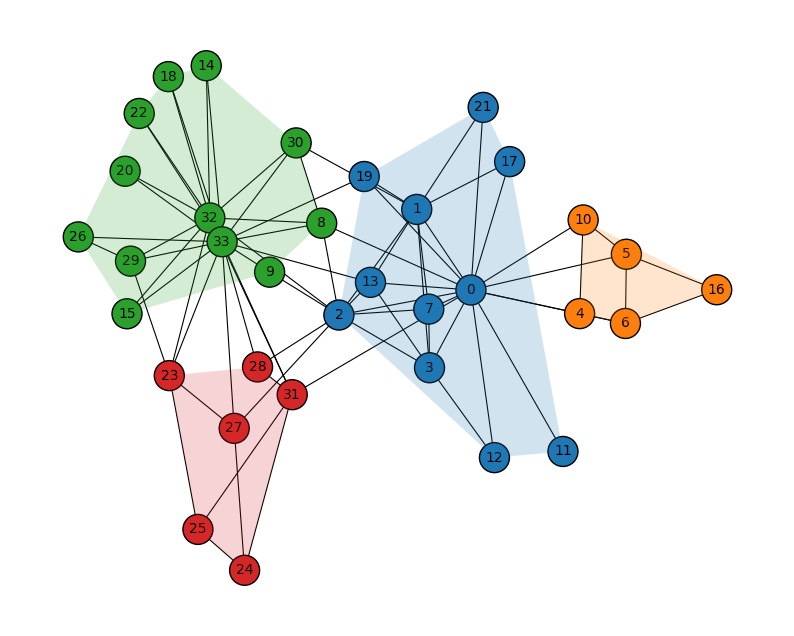

In [11]:

def communities_w_shading_viz(graph, communities, title="Community Structure Visualization"):
    # Get node colors based on detected communities
    num_communities = len(communities)
    node_colors_map = plt.colormaps['tab10'] # Using 'tab10' as it's common and good for discrete categories
                                            # If more than 10 communities, consider 'tab20' or 'viridis' etc.
    vertex_colors = [node_colors_map(communities.membership[i] % node_colors_map.N) for i in range(graph.vcount())]
    # Use modulo operator (%) with node_colors_map.N to handle more communities than colors in 'tab10'
    # For example, if tab10 has 10 colors, community 10 will get color 0, community 11 will get color 1, etc.


    # --- 2. Force-Directed Layout ---
    layout = graph.layout("fr") # Fruchterman-Reingold layout for spatial separation of communities

    # --- 3. Edge Coloring (Black Edges like in your example) ---
    edge_colors = ["black"] * graph.ecount()
    edge_width = 0.8

    # --- 4. Plotting with Matplotlib for Community Shading ---
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_facecolor('white') # Explicitly set background to white

    # Plot the graph first
    ig.plot(
        graph,
        target=ax,
        layout=layout,
        vertex_color=vertex_colors, # Use the computed vertex_colors list
        vertex_size=30, # Adjust size as needed
        vertex_label=[str(i) for i in range(graph.vcount())], # Use graph.vcount() here
        vertex_label_size=10, # Adjusted for better visibility in plots
        vertex_label_color="black",
        edge_color=edge_colors,
        edge_width=edge_width,
        edge_curved=False,
        # bbox=(500, 500), # Not needed here as figsize handles the overall plot size
        margin=50
    )

    # --- 5. Add Community Shading (Blobs) ---
    for i in range(num_communities):
        community_nodes_indices = [v.index for v in graph.vs if communities.membership[v.index] == i]

        if len(community_nodes_indices) > 2: # Need at least 3 points for a meaningful convex hull
            community_coords = np.array([layout[idx] for idx in community_nodes_indices])

            try: # Use a try-except block for ConvexHull, as it can fail with collinear points
                hull = ConvexHull(community_coords)
                hull_points = community_coords[hull.vertices]

                patch = plt.Polygon(hull_points,
                                    facecolor=node_colors_map(i % node_colors_map.N), # Use the colormap directly
                                    alpha=0.2,
                                    edgecolor='none',
                                    zorder=0)
                ax.add_patch(patch)
            except Exception as e:
                # Handle cases where ConvexHull might fail (e.g., all points collinear)
                # For small communities (2 or 1 node), this block will be skipped due to len(community_nodes_indices) > 2 check
                print(f"Warning: Could not draw convex hull for community {i}. Error: {e}")
                # Fallback for very small or problematic communities:
                if len(community_coords) == 1:
                    ax.add_patch(plt.Circle(community_coords[0], radius=0.08, color=node_colors_map(i % node_colors_map.N), alpha=0.2, zorder=0))
                elif len(community_coords) == 2:
                    min_x, min_y = np.min(community_coords, axis=0)
                    max_x, max_y = np.max(community_coords, axis=0)
                    center_x = (min_x + max_x) / 2
                    center_y = (min_y + max_y) / 2
                    width = max_x - min_x + 0.1
                    height = max_y - min_y + 0.1
                    ax.add_patch(plt.Rectangle((min_x - 0.05, min_y - 0.05), width, height,
                                                color=node_colors_map(i % node_colors_map.N), alpha=0.2, zorder=0))
        elif len(community_nodes_indices) == 1:
            community_coords = np.array([layout[idx] for idx in community_nodes_indices])
            ax.add_patch(plt.Circle(community_coords[0], radius=0.08, color=node_colors_map(i % node_colors_map.N), alpha=0.2, zorder=0))
        elif len(community_nodes_indices) == 2:
            community_coords = np.array([layout[idx] for idx in community_nodes_indices])
            min_x, min_y = np.min(community_coords, axis=0)
            max_x, max_y = np.max(community_coords, axis=0)
            width = max_x - min_x + 0.1
            height = max_y - min_y + 0.1
            ax.add_patch(plt.Rectangle((min_x - 0.05, min_y - 0.05), width, height,
                                        color=node_colors_map(i % node_colors_map.N), alpha=0.2, zorder=0))

communities_w_shading_viz(g, clusters)

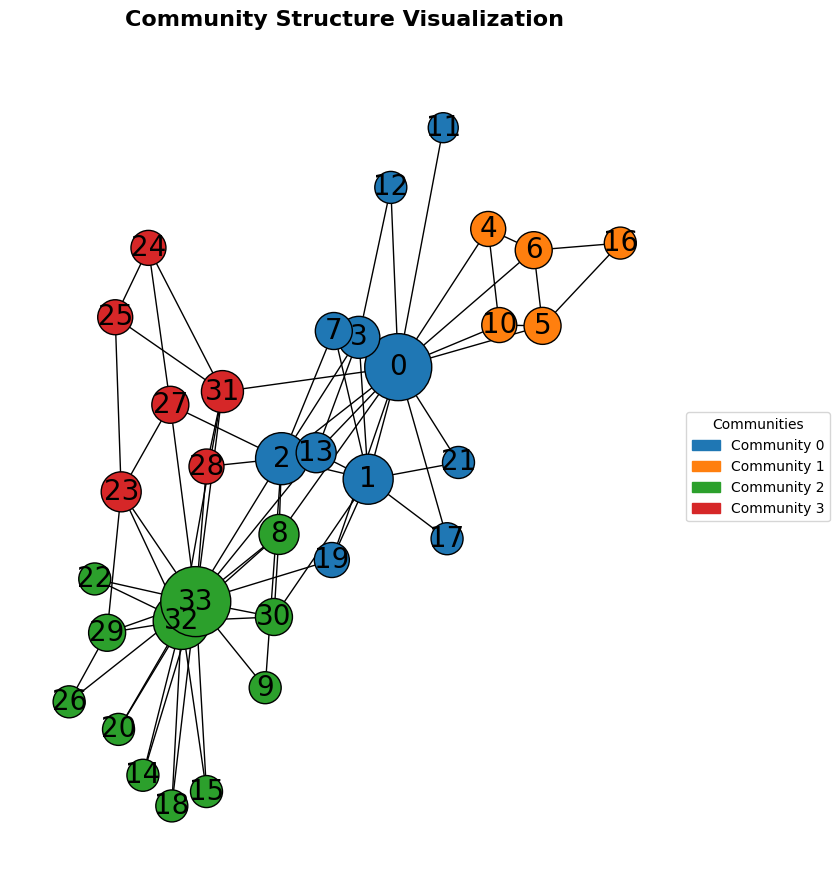

In [12]:
def degree_based_node_sizes_community_viz(graph, communities, title="Community Structure Visualization"):
    """
    Creates a publication-quality figure of a graph with clustered communities.

    Args:
        graph (igraph.Graph): The graph object.
        communities (igraph.VertexClustering): The detected communities object.
        title (str): The main title for the figure.
    """
    # 1. Define a color palette for communities
    num_communities = len(set(communities.membership))
    
    # Set the title
    title = "Community Structure Visualization"

    node_colors = []
    node_colors = [matplotlib.colormaps["tab10"](cluster_id) for cluster_id in communities.membership]

    graph.vs["color"] = node_colors # Assign color as a vertex attribute

    # 2. Choose an Appropriate Layout Algorithm
    layout = graph.layout("fr") # "fr" for Fruchterman-Reingold

    # 3. Size Nodes Meaningfully (Example: by degree)
    degrees = graph.degree()
    min_degree = min(degrees) if degrees else 0
    max_degree = max(degrees) if degrees else 1
    if max_degree == min_degree:
        node_sizes = [30 for _ in degrees]
    else:
        node_sizes = [30 + 40 * ((d - min_degree) / (max_degree - min_degree)) for d in degrees]
    
    graph.vs["size"] = node_sizes # Assign size as a vertex attribute

    # 4. Create Matplotlib Figure and Axes
    fig, ax = plt.subplots(figsize=(10, 9))

    # 5. Plot the graph onto the axes
    ig.plot(
        graph,
        target=ax,
        layout=layout,
        vertex_color=graph.vs["color"],
        vertex_size=graph.vs["size"],
        vertex_label=[str(i) for i in range(g.vcount())],
        vertex_label_size=20,
        vertex_label_color="black",
        edge_width=1,      # Set edge width directly here
        edge_color="#000000", # Set edge color directly here
        bbox=(0, 0, 800, 700),
        margin=50
    )

    # 6. Add a Descriptive Title
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)

    # 7. Add a Legend for Communities
    legend_handles = []
    # Ensure all community IDs are covered for the legend
    unique_community_ids = sorted(list(set(communities.membership)))
    for i in unique_community_ids:
        # Find an example node color for this community ID
        # This is robust even if a community is empty in the sample but theoretically exists
        try:
            # Find the color of the first node belonging to this community
            color_for_community = graph.vs[communities.membership.index(i)]["color"]
        except ValueError:
            # Fallback if no nodes in this community (shouldn't happen with detected communities)
            # Use a default color or cycle through the base_colors if a community has no nodes
            color_for_community = base_colors[i % len(base_colors)]

        # Correct usage: Patch is imported directly
        patch = Patch(color=color_for_community, label=f'Community {i}')
        legend_handles.append(patch)
    
    ax.legend(handles=legend_handles, title="Communities", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)

    # 8. Remove axis ticks and labels for cleaner graph visualization
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.axis('off')

    # 9. Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    # Display the plot
    plt.show()



    
    
degree_based_node_sizes_community_viz(g, clusters)